In [1]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [2]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/data"
DATA_DIR = "garbage_dataset/Garbage classification/Garbage classification"

path = os.path.join(BASE_DIR, DATA_DIR)


In [3]:
target_size = (224, 224)
waste_labels = {
    "trash": 0,
    "plastic": 1,
    "paper": 2,
    "metal": 3,
    "glass": 4,
    "cardboard": 5
}

In [6]:
def load_datasets(path):
  x = []
  labels = []

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)

    img = cv2.resize(img, target_size)

    x.append(img)

    label = image_path.split(os.path.sep)[-2]
    labels.append(label)  # Append the label to the labels list

  x, labels = shuffle(x, labels, random_state=42)

  print("Shape of X: ", np.array(x).shape)
  print("Num of Unique Labels: ", len(np.unique(labels)), "Num of Labels", len(labels))

  return x, labels

In [7]:
x, labels = load_datasets(path)

Shape of X:  (2527, 224, 224, 3)
Num of Unique Labels:  6 Num of Labels 2527


In [9]:
input_shape = np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3
print(input_shape)

(224, 224, 3)


In [14]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for i in range(10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(image_batch[i])
    # Convert string labels to integer labels using waste_labels dictionary
    integer_labels = [waste_labels[label] for label in label_batch]
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(integer_labels, num_classes=6)[i]==1][0].title())
    plt.axis("off")

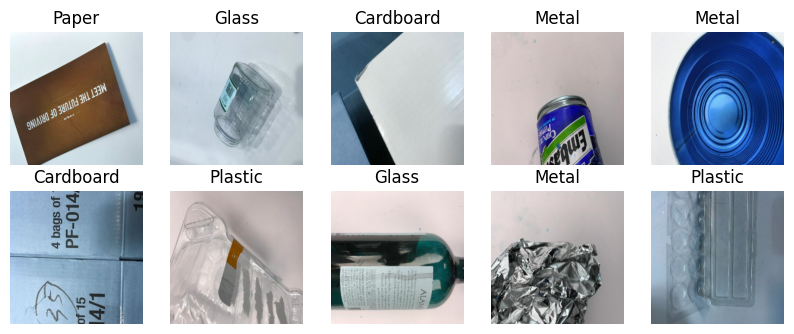

In [15]:
visualize_img(x, labels)

In [16]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

test = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.1
)

In [17]:
train_generator = train.flow_from_directory(directory=path,
                                            target_size=(target_size),
                                            class_mode="categorical",
                                            subset="training")

test_generator = test.flow_from_directory(directory=path,
                                          target_size=(target_size),
                                          batch_size=251,
                                          class_mode="categorical",
                                          subset="validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [20]:
input_shape = np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=2, strides=(2,2)),

    Flatten(),

    Dense(units=64, activation="relu"),
    Dropout(rate=0.2),

    Dense(units=32, activation="relu"),
    Dropout(rate=0.2),

    Dense(units=6, activation="softmax")
])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,366 (6.21 MB)

 Trainable params: 1,627,366 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [24]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=50, verbose=0, mode="min"), # mode -> val_loss un azalması durduğunda model duracak
    ModelCheckpoint(filepath="cnn_model.keras", monitor="val_loss", mode="min",
                    save_best_only=True, save_weights_only=False, verbose=0)
]

In [29]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks,
    steps_per_epoch=2276//32,
    validation_steps=251//32
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 527ms/step - accuracy: 0.2204 - loss: 1.7529 - precision: 0.3937 - recall: 0.0115 - val_accuracy: 0.3267 - val_loss: 1.5958 - val_precision: 0.8500 - val_recall: 0.0677
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2188 - loss: 1.6801 - precision: 1.0000 - recall: 0.0625 - val_accuracy: 0.3386 - val_loss: 1.5789 - val_precision: 0.9333 - val_recall: 0.0558
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - accuracy: 0.3347 - loss: 1.5501 - precision: 0.7466 - recall: 0.0898 - val_accuracy: 0.3865 - val_loss: 1.4710 - val_precision: 0.8636 - val_recall: 0.0757
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5625 - loss: 1.2137 - precision: 1.0000 - recall: 0.2500 - val_accuracy: 0.3745 - val_loss: 1.4755 - val_precision: 0.8276 - val_recall: 0.0956
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 416ms/step - accuracy: 0.3609 - loss: 1.4836 - precision: 0.6571 - recall: 0.1425 - val_accuracy: 0.4183 - val_lo

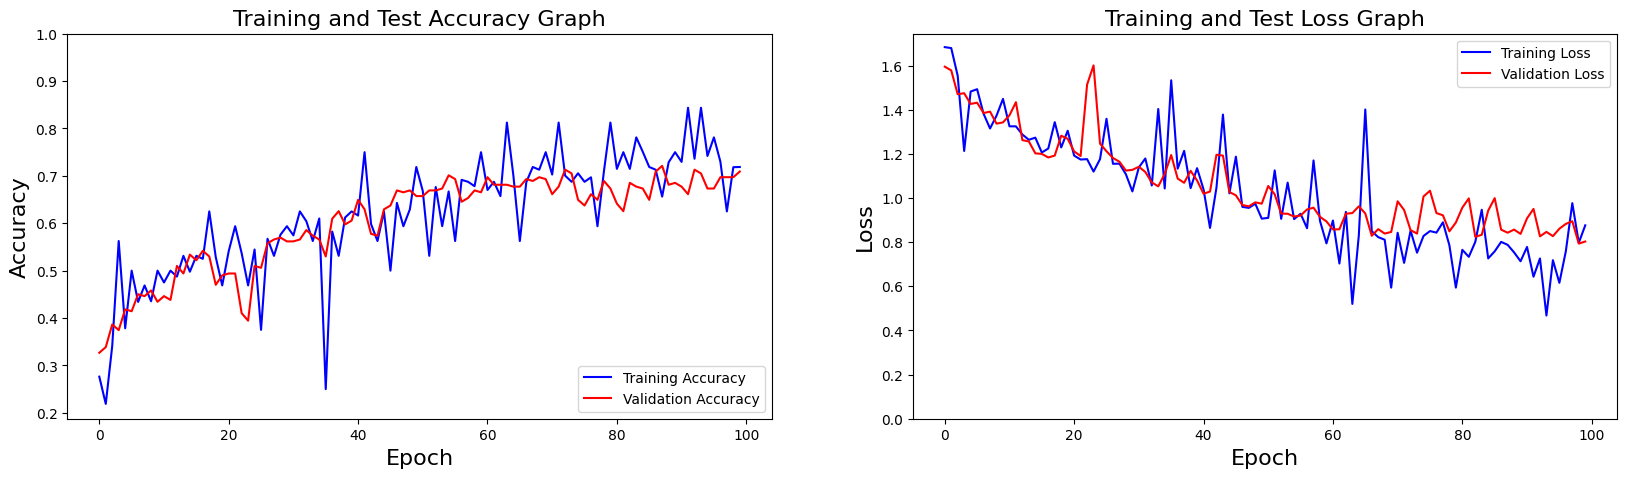

In [30]:
# Evaluation

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Test Accuracy Graph', fontsize=16)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Test Loss Graph', fontsize=16)
plt.show()

In [31]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
print(f"Loss: {loss * 100:.2f}, Precision: {precision * 100:.2f}, Recall: {recall * 100:.2f}, Accuracy: {acc * 100:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7092 - loss: 0.8033 - precision: 0.8297 - recall: 0.6016
Loss: 80.33, Precision: 82.97, Recall: 60.16, Accuracy: 70.92


In [33]:
X_test, y_test = next(test_generator)
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


In [34]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


In [35]:
target_names = list(waste_labels.keys())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       trash       0.87      0.65      0.74        40
     plastic       0.64      0.78      0.70        50
       paper       0.55      0.66      0.60        41
       metal       0.79      0.93      0.85        59
       glass       0.78      0.44      0.56        48
   cardboard       0.71      0.77      0.74        13

    accuracy                           0.71       251
   macro avg       0.72      0.70      0.70       251
weighted avg       0.73      0.71      0.70       251



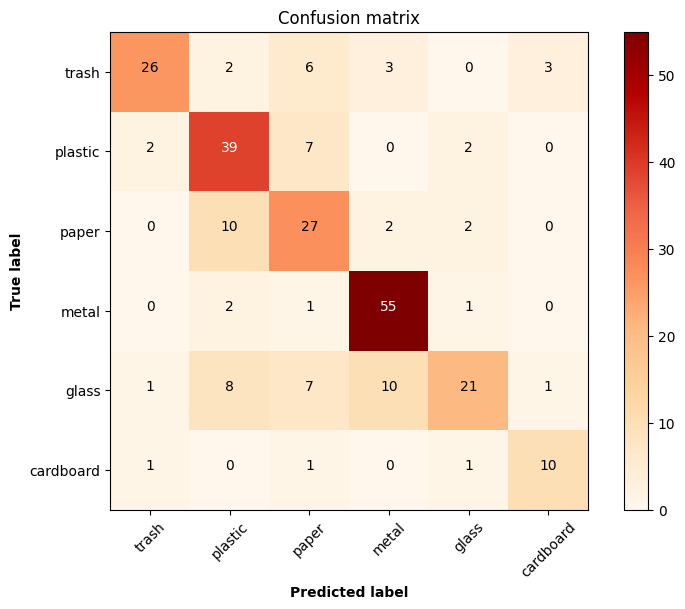

In [36]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")

plot_confusion_matrix(cm, waste_labels.keys(), title='Confusion matrix', cmap=plt.cm.OrRd)